In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy.stats import norm

from math import *

In [2]:
def HeMC (S0, r, v0, rho, kappa, theta, xi, T, dt):

    # Generate a Monte Carlo simulation for the Heston model

    # Generate random Brownian Motion
    MU  = np.array([0, 0])
    COV = np.matrix([[1, rho], [rho, 1]])
    W   = np.random.multivariate_normal(MU, COV, T)
    W_S = W[:,0]
    W_v = W[:,1]

    # Generate paths
    vt    = np.zeros(T)
    vt[0] = v0
    St    = np.zeros(T)
    St[0] = S0
    for t in range(1,T):
        vt[t] = np.abs(vt[t-1] + kappa*(theta-np.abs(vt[t-1]))*dt + xi*np.sqrt(np.abs(vt[t-1]))*np.sqrt(dt)*W_v[t])
        St[t] = St[t-1]*np.exp((r - 0.5*vt[t-1])*dt + np.sqrt(vt[t-1]*dt)*W_S[t])

    return St, vt

In [3]:
T     = 252
dt    = 1/252 # 
S0    = 100 # Initial price
rho   = -0.2 # Correlation
kappa = 0.3 # Revert rate
theta = 0.2 # Long-term volatility
xi    = 0.2 # Volatility of instantaneous volatility
v0    = 0.2 # Initial instantaneous volatility
r = 0.05

In [4]:
St,vt = HeMC(S0, r, v0, rho, kappa, theta, xi, T, dt)

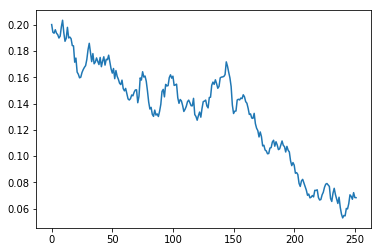

In [5]:
plt.plot(vt)

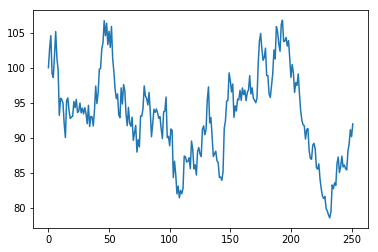

In [6]:
plt.plot(St)

In [7]:
def HeMC_paths(S0, r, v0, rho, kappa, theta, xi, T, dt, nb_scenarios):

    # Generate a Monte Carlo simulation for the Heston model
    MU  = np.array([0, 0])
    COV = np.matrix([[1, rho], [rho, 1]])
    
    simulation_df = pd.DataFrame()
    for scenarioNumber in range(nb_scenarios):
        # Generate random Brownian Motion
        W   = np.random.multivariate_normal(MU, COV, T)
        W_S = W[:,0]
        W_v = W[:,1]
        # Generate paths
        vt    = np.zeros(T)
        vt[0] = v0
        St    = np.zeros(T)
        St[0] = S0

        for t in range(1,T):
            vt[t] = np.abs(vt[t-1] + kappa*(theta-np.abs(vt[t-1]))*dt + xi*np.sqrt(np.abs(vt[t-1]))*np.sqrt(dt)*W_v[t])
            St[t] = St[t-1]*np.exp((r - 0.5*vt[t-1])*dt + np.sqrt(vt[t-1]*dt)*W_S[t])
        simulation_df[scenarioNumber] = St

    return simulation_df

In [8]:

def CalculatePrice(strike, r,T,df_prices_per_scenario, nb_sims):
    pay_offs = 0
    total_scenarios = nb_sims
    df_prices_per_scenario_mat = df_prices_per_scenario.loc[:T]
    for i in range(total_scenarios):
        price = df_prices_per_scenario_mat[i].values.tolist()[-1]
        pay_off = price - strike
        if(pay_off>0): 
            pay_offs=pay_offs+pay_off

    discounted_price = (np.exp(-r * (T/365))*pay_offs)
    result = discounted_price/total_scenarios
    return result
    
    

In [9]:
def plot_scenario_paths(df_prices_per_scenario, nb_scenarios, timestep):
    plt.figure(figsize=(14,8))
    for i in range(nb_scenarios):            
        plt.plot((df_prices_per_scenario.index)*timestep, df_prices_per_scenario[i])            

    plt.ylabel('Stock Value')
    plt.xlabel('Timestep')
    plt.show()

In [10]:
n = norm.pdf
N = norm.cdf

def bs_price(cp_flag,S,K,T,r,v,q=0.0):
    d1 = (log(S/K)+(r+v*v/2.)*T)/(v*sqrt(T))
    d2 = d1-v*sqrt(T)
    if cp_flag == 'c':
        price = S*exp(-q*T)*N(d1)-K*exp(-r*T)*N(d2)
    else:
        price = K*exp(-r*T)*N(-d2)-S*exp(-q*T)*N(-d1)
    return price

def bs_vega(cp_flag,S,K,T,r,v,q=0.0):
    d1 = (log(S/K)+(r+v*v/2.)*T)/(v*sqrt(T))
    return S * sqrt(T)*n(d1)

In [11]:
def find_imp_vol(target_value, S, K, T, r, call_put="c"):
    MAX_ITERATIONS = 100
    PRECISION = 1.0e-5

    sigma = 0.5
    for i in range(0, MAX_ITERATIONS):
        price = bs_price(call_put, S, K, T, r, sigma)
        vega = bs_vega(call_put, S, K, T, r, sigma)

        price = price
        diff = target_value - price  # our root

        #print(i, sigma, diff)

        if (abs(diff) < PRECISION):
            return sigma
        sigma = sigma + diff/vega # f(x) / f'(x)

    # value wasn't found, return best guess so far
    return sigma

In [28]:
#implied_volatility(9,273,)

In [19]:
K = 100
mat = 20
r = 0.05
option_price = CalculatePrice(K,r,mat,simulation_df,nb_scenarios)

In [20]:
option_price

6.089804980192465

In [12]:
def read_data(date,index="SPY",indicator="impliedV"):
    path = os.path.join("data",indicator,index,date+"_"+index+"~market__"+indicator+".csv")
    df = pd.read_csv(path)
    return(df)

In [13]:
def get_iv_atm(expiry,df):
    df1 = df[df.expiry == expiry]
    df_bis = df1.drop_duplicates("expiry")
    df_bis["strike"] = df_bis["fwd"]
    df_bis["midImpliedV"] = np.nan
    df1 = df1.append(df_bis,ignore_index=True)
    df1.sort_values("strike",inplace=True)
    df1["midImpliedV"] = df1["midImpliedV"].interpolate()
    return(df1[df1["strike"] == df1["fwd"]]["midImpliedV"].values[0])

In [14]:
def add_iv_atm_col(df):
    def change_iv_atm(r,expiry,v):
        if r["expiry"]==expiry:
            r["IV_ATM"]=v
        return r
    # compute of IV_ATM of each expiry and add it to the column df["IV_ATM"]
    df["IV_ATM"] = np.nan
    for expiry in df.expiry.unique():
        v = get_iv_atm(expiry,df)
        df = df.apply(lambda r: change_iv_atm(r,expiry,v), axis=1)
    return df


In [15]:
df_iv = read_data("20180108")
df_iv["expiry"] = df_iv["expiry"].astype("str")
df_iv["expiry"] = pd.to_datetime(df_iv["expiry"],format="%Y-%m-%d")

In [16]:
df_iv = add_iv_atm_col(df_iv)
df_iv["Moneyness"] = np.log(df_iv["strike"]/df_iv["fwd"])/(np.sqrt(df_iv["tenor"])*df_iv["IV_ATM"])

/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [17]:
df_iv_groupBy = df_iv.groupby(["tenor","strike","expiry"]).mean()
df_iv_groupBy.reset_index("expiry",inplace=True)

In [18]:
df_iv_groupBy.head()

expiry  cleanExpiry    vTenor        spot         fwd  \
tenor    strike                                                             
0.005451 265.5  2018-01-10     20180110  0.005815  273.972444  273.934799   
         266.0  2018-01-10     20180110  0.005815  273.972444  273.934799   
         266.5  2018-01-10     20180110  0.005815  273.972444  273.934799   
         267.0  2018-01-10     20180110  0.005815  273.972444  273.934799   
         267.5  2018-01-10     20180110  0.005815  273.972444  273.934799   

                 pcIndicator  volume  openInterest  bidPrice  offerPrice  \
tenor    strike                                                            
0.005451 265.5          -1.0   101.0        1136.0      0.01        0.02   
         266.0          -1.0    10.0        2708.0      0.01        0.02   
         266.5          -1.0    50.0        5670.0      0.01        0.02   
         267.0          -1.0   354.0        4730.0      0.01        0.02   
         267.5          -1.0   316.0        6800.0      0.01        0.02   

                 midPrice  bidImpliedV  offerImpliedV  midImpliedV  \
tenor    strike                                                      
0.005451 265.5      0.015     0.171806       0.188126     0.180908   
         266.0      0.015     0.162738       0.178330     0.171419   
         266.5      0.015     0.153594       0.168488     0.161871   
         267.0      0.015     0.144338       0.158635     0.152265   
         267.5      0.015     0.135104       0.148615     0.142643   

                 criticalSpot    IV_ATM  Moneyness  
tenor    strike                                     
0.005451 265.5           -1.0  0.061269  -6.913917  
         266.0           -1.0  0.061269  -6.497987  
         266.5           -1.0  0.061269  -6.082839  
         267.0           -1.0  0.061269  -5.668468  
         267.5           -1.0  0.061269  -5.254873

In [23]:
#dic_params{0:}

In [ ]:
theta = 0.0218
kappa = 6.728594 
sigma = 2.250845 
rho = -0.520689
v0 = 0.003637

In [19]:
def find_sigma0(df_iv_groupBy,min_maturity):
    df_min_mat = df_iv_groupBy.loc[min_maturity].reset_index()
    sigma0 = df_min_mat["IV_ATM"].unique()[0]
    return sigma0

def compute_iv_Heston_fixedDate(df_iv_groupBy, index_dic_param = 2, tenor_min=0,tenor_max = 1):
    tenor_list_unique = sorted(df_iv_groupBy.index.get_level_values(0).unique())
    df_iv_groupBy["iv_rough_vol_"+str(index_dic_param)] = np.nan
    theta = 0.029416
    kappa = 3.391330 
    sigma = 1.752326 
    rho = -0.623504 
    v0 = 0.004728

    r = 0.05
    S0 = df_iv_groupBy["spot"].values[0]
    print("spot :",S0)
    #sigma0 = find_sigma0(df_iv_groupBy,tenor_list_unique[0])
    T_max = 252
    dt = 1/252
    nb_scenarios = 100000
    simulation_df = HeMC_paths(S0, r, v0, rho, kappa, theta, sigma, T_max, dt, nb_scenarios)
    plot_scenario_paths(simulation_df, nb_scenarios, dt)
    for tenor in tenor_list_unique:
        if (tenor>=tenor_min) and (tenor<=tenor_max):
            strike_list = df_iv_groupBy.loc[tenor].index
            for strike in strike_list:
                maturity_days = int(tenor*365)+1
                print("maturity in days : "+str(maturity_days)+" , strike : "+str(strike))
                
                option_price = CalculatePrice(strike,r,maturity_days,simulation_df,nb_scenarios)
                mat_year = maturity_days/365
                iv = find_imp_vol(option_price,S0,strike,mat_year,r)
                print("option price with Monte carlo method : ",option_price)
                print("implied vol with BS formula inversion : ",iv)
                df_iv_groupBy.loc[(tenor,strike),"iv_rough_vol_"+str(index_dic_param)] = iv
        elif tenor>=tenor_max:
            break;
    return df_iv_groupBy

In [20]:
#implied_volatility(12.54,273.9,264,4,0.05)

In [21]:
#implied_volatility(11.8,273.9,265,4,0.05)

In [ ]:
df_iv_groupBy = compute_iv_Heston_fixedDate(df_iv_groupBy,tenor_min=0,tenor_max = 1)

spot : 273.97244356448954


KeyboardInterrupt: 

In [ ]:
def plot_term_struct(df_iv_groupBy,index_dic_param=2, strikes_list=[235,250,260,270,280,290]):
    plt.figure(figsize=(16, 10))
    for i,strike in  enumerate(strikes_list):
        ax = plt.subplot(3, 3, i+1)
        df_iv_grouBy_reset = df_iv_groupBy.reset_index("strike")
        df_term_st = df_iv_grouBy_reset[df_iv_grouBy_reset["strike"]==strike]
        df_term_st[["expiry","iv_rough_vol_"+str(index_dic_param)]].set_index("expiry").plot(ax=ax)
        df_term_st[["expiry","midImpliedV"]].set_index("expiry").plot(ax=ax)
        plt.title("Strike : "+strike)
        plt.tight_layout()

In [553]:
def plot_vol_surface(df,index_dic_param,x_col="expiry",y_col="strike",target_z_col="midImpliedV",tenor_max=None):
    df = df.reset_index()
    if tenor_max is not None:
        df = df[df["tenor"]<tenor_max]
    df_pivot = df.pivot(index=x_col,columns=y_col,values=target_z_col+"_"+str(index_dic_param))
    fig = go.Figure(data=[go.Surface(x=df_pivot.columns.values,y=df_pivot.index ,z=df_pivot.values)])

    fig.update_layout(title='volatility surface', autosize=False,
                      width=800, height=600,
                      margin=dict(l=65, r=50, b=65, t=90))

    fig.show()

In [603]:
def plot_iv_skew(df_iv_groupBy, index_dic_param=2, exp_dates_list=["20180110","20180112","20180216","20180316",
                                                                  '20180420', '20180615', '20180720', '20180921', 
                                                                   '20181221']):
    plt.figure(figsize=(16, 10))
    for i,expiry_date in  enumerate(exp_dates_list):
        ax = plt.subplot(3, 3, i+1)
        df_iv_grouBy_reset = df_iv_groupBy.reset_index("tenor")
        df_iv_grouBy_reset[df_iv_grouBy_reset["expiry"]==expiry_date][["midImpliedV"]].plot( ax=ax)
        df_iv_grouBy_reset[df_iv_grouBy_reset["expiry"]==expiry_date][["iv_rough_vol_"+str(index_dic_param)]].plot(ax=ax)
        plt.axvline(x=df_iv_grouBy_reset[df_iv_grouBy_reset["expiry"]==expiry_date]["spot"].unique(),color='red')
        plt.title("expiry date : "+expiry_date)
        plt.legend()
        plt.tight_layout()

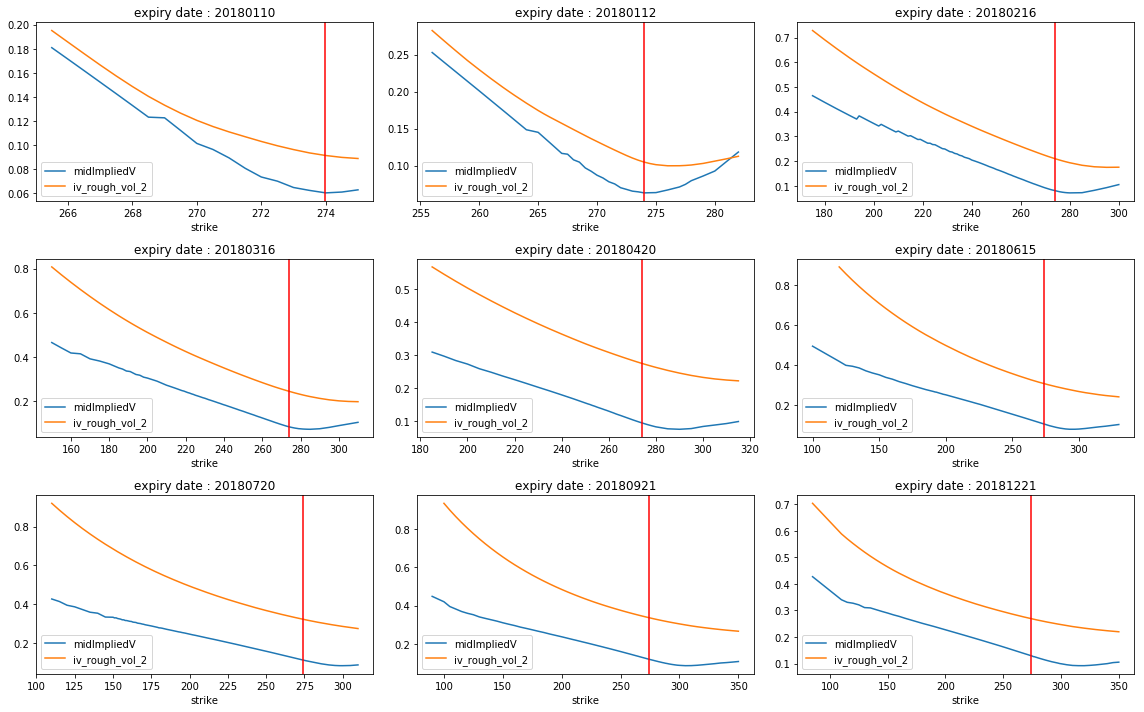

In [604]:
plot_iv_skew(df_iv_groupBy)

In [ ]:
plot_term_struct(df_iv_groupBy)